# Download Dataset

In [1]:
import os
from pathlib import Path
import requests

In [2]:
# define workspace and data folder
WORK_DIR = Path('D:/work/workspace/machine_learning/Datasets')
DATA_PATH = WORK_DIR / 'FACIAL_POSE'

URL = 'https://download.pytorch.org/tutorial/'
FILE_NAME = 'faces.zip'

# create data directory
DATA_PATH.mkdir(exist_ok=True, parents=True)

# download files 
if not (DATA_PATH/FILE_NAME).exists():
    content = requests.get(URL+FILE_NAME).content
    (DATA_PATH/FILE_NAME).open('wb').write(content)

# WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS

In [3]:
from __future__ import print_function, division
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

import warnings
warnings.filterwarnings('ignore')

plt.ion()

A lot of effort in solving any machine learning problem goes in to preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable. In this tutorial, we will see how to load and preprocess/augment data from a non trivial dataset.

The dataset we are going to deal with is that of facial pose. This means that a face is annotated.

Dataset comes with a csv file with annotations which looks like this:

`image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312`

Let’s quickly read the CSV and get the annotations in an (N, 2) array where N is the number of landmarks

In [4]:
faces_landmarks = pd.read_csv((DATA_PATH/'faces/face_landmarks.csv').as_posix())

n = 65 
img_name = faces_landmarks.iloc[n, 0]
landmarks = faces_landmarks.iloc[n, 1:].values
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


Let’s write a simple helper function to show an image and its landmarks and use it to show a sample.

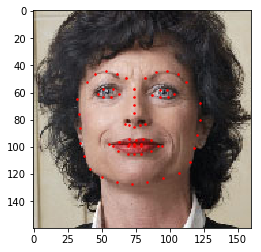

In [5]:
def show_landmarks(image, landmarks):
    """
    Show image with landmarks.
    
    Args:
        image (numpy.ndarray): Input image.
        landmarks (numpy.ndarray): Facial annotations.    
    """
    
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join(str(DATA_PATH), 'faces', img_name)),
               landmarks)
plt.show()

# Dataset class

torch.utill.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit from Datset class and override the followign methods:

- __len__ so that len(dataset) returns the size of the dataset
- __getitem__ to support indexing such that dataset[i] returns the ith index

Let’s create a dataset class for our face landmarks dataset. We will read the csv in __init__ but leave the reading of images to __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict {'image': image, 'landmarks': landmarks}. Our dataset will take an optional argument transform so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section.

In [18]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks Dataset."""
    
    def __init__(self, landmark_path, img_dir, transform=None):
        """
        Args:
            landmark_path (string): Path to annotation csv file.
            img_dir (string): Path to images directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(landmark_path)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        # deal with tensor input
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.landmarks_frame.iloc[idx, 0]
        image = io.imread(os.path.join(self.img_dir, img_name))
        landmarks = self.landmarks_frame.iloc[idx, 1:].values
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {"image": image, "landmarks": landmarks}
        
        if self.transform is not None:
            sample = self.transform(sample)      
        
        return sample

Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

0 (324, 215, 3) (68, 2)


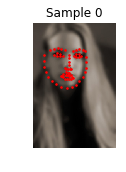

1 (500, 333, 3) (68, 2)


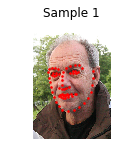

2 (250, 258, 3) (68, 2)


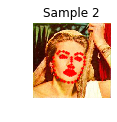

3 (434, 290, 3) (68, 2)


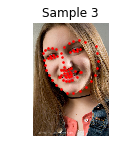

In [27]:
FACES_PATH = (DATA_PATH/'faces')
face_dataset = FaceLandmarksDataset((FACES_PATH/"face_landmarks.csv").as_posix(), FACES_PATH.as_posix())

fig = plt.figure()

for i in range(len(faces_dataset)):
    sample = faces_dataset[i]
    
    print(i, sample["image"].shape, sample["landmarks"].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f"Sample {i}")
    ax.axis("off")
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

# Transforms
One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create three transforms:

- Rescale: to scale the image
- RandomCrop: to crop from image randomly. This is data augmentation.
- ToTensor: to convert the numpy images to torch images (we need to swap axes).

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement __call__ method and if required, __init__ method. We can then use a transform like this:

`tsfm = Transform(params)
transformed_sample = tsfm(sample)`

Observe below how these transforms had to be applied both on the image and landmarks.

The __init__ is automatically called so, for it no need of docstring instead place it in the class docstring.
Similarly for __call__, docstring is already there in class, so mention only args and returns

Use isinstance to check types npt type

In [28]:
# inherit object class, to gain its functionalities
class Rescale(object):
    """Rescale sample image to given output size, hence transform landmarks as well.
    
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is matched to 
            output_size. If int, smaller of image edges is matched to output_size keeping 
            aspect ratio the same.
    """
    
    def __init__(self, output_size):
        # use assert to check type (debbugging) 
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __name__(self):
        return 
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)    
        
        image = transform.resize(image, (new_h, new_w)) # here transform is from sk-image
        
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h] # multiply the nos in the axis specified
        
        return {'image': image, 'landmarks': landmarks}

    
class RandomCrop(object):
    """Randomly crop given sample image.
    
    Args:
        output_size (int or tuple): Desired output size. If int, square 
            crop is made.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (tuple, int)) # verify type
        if isinstance(output_size, int): # condition
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2 # verify length
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h, 
                      left: left + new_w]
        landmarks = landmarks - [left, top]
        
        return {"image": image, "landmarks": landmarks}
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image),
                "landmarks": torch.from_numpy(landmarks)}

# Compose Transforms

Now, we apply the transforms on a sample.

Let’s say we want to rescale the shorter side of the image to 256 and then randomly crop a square of size 224 from it. i.e, we want to compose Rescale and RandomCrop transforms. torchvision.transforms.Compose is a simple callable class which allows us to do this.

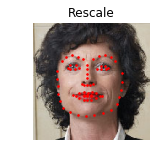

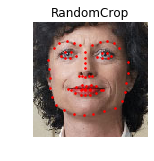

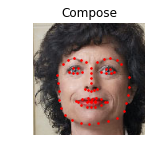

In [29]:
scale = Rescale(256)
rcrop = RandomCrop(128)
compose = transforms.Compose([Rescale(256), 
                              RandomCrop(224)])

plt.figure()

sample = face_dataset[65]
for i, tform in enumerate([scale, rcrop, compose]):
    transformed_sample = tform(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    # to get the name of custom class, implemet __name__ or try type(class).__name__ to get the name
    ax.set_title(type(tform).__name__)
    ax.axis('off')
    show_landmarks(**transformed_sample)
    plt.show()

# Iterating through the dataset
Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

An image is read from the file on the fly
Transforms are applied on the read image
Since one of the transforms is random, data is augmentated on sampling
We can iterate over the created dataset with a for i in range loop as before.

In [30]:
tform = transforms.Compose([Rescale(225), 
                                RandomCrop(224), 
                                ToTensor()])
transformed_dataset = FaceLandmarksDataset(os.path.join(str(FACES_PATH), "face_landmarks.csv"),
                                           img_dir=str(FACES_PATH), transform=tform)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample["image"].shape, sample["landmarks"].shape)
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

**Note:** use the collate_fn to define the sampling process

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


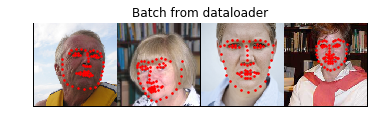

In [36]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # all images printed in on go show in show_landmarks, 
    # so see 4th iteration and print and stop
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Afterword: torchvision
In this tutorial, we have seen how to write and use datasets, transforms and dataloader. torchvision package provides some common datasets and transforms. You might not even have to write custom classes. One of the more generic datasets available in torchvision is ImageFolder. It assumes that images are organized in the following way:

`root/ants/xxx.png
 root/ants/xxy.jpeg
 root/ants/xxz.png
 .
 .
 .
 root/bees/123.jpg
 root/bees/nsdf3.png
 root/bees/asd932_.png`

where ‘ants’, ‘bees’ etc. are class labels. Similarly generic transforms which operate on PIL.Image like RandomHorizontalFlip, Scale, are also available. You can use these to write a dataloader like this: